## <center>Assignment</center>

### 1. Dataset

The Arrhythmia dataset from UCI repository contains 280 variables collected from 452 patients. Its information helps in distinguishing between the presence and absence of cardiac arrhythmia and in classifying arrhytmia in one of the 16 groups. In this homework, we will just focus on building a Logistic Regression model that can classify between the presence and absence of arrhythmia.


Original class 1 refers to 'normal' ECG which we will regard as 'absence of arrhythmia' and the rest of the classes will be 'presence of arrhythmia'.

In [55]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [56]:
#load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                   'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


In [57]:
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 280 columns


In [58]:
np.unique(data[len(data.columns)-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16])

### 1-1 多類分為兩類

Let's make that column (class label) dichotomous.
Value is 0 if ECG is normal, 1 otherwise

In [59]:
# if class = 1 -> 0, else -> 1
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

In [60]:
data.groupby(['arrhythmia']).size()

arrhythmia
0    245
1    207
dtype: int64

### 1-2 空缺資料處理 - 直接刪除有缺失資料的feature

Some columns have missing values denoted as '?'
To make the preprocessing simpler, let's just retain the columns with numeric values.

In [61]:
# 透過data._get_numeric_data()，只會選擇保留數值型欄位，而刪除非數值型欄位
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 275 columns


In [62]:
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [63]:
X = data.iloc[:, :-1]  # The first to second-last columns are the 'features'
y = data.iloc[:, -1]   # The last column is the ground-truth 'label'
print(np.unique(y))
print(X.shape)

[0 1]
(452, 274)


In [64]:
from sklearn.model_selection  import train_test_split

# splitting the dataset to training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20181004)

In [65]:
from sklearn.preprocessing import StandardScaler

# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

1. entropy

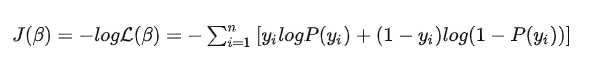

2. gradient descent

In [66]:
class LogisticRegression(object):

    def __init__(self, eta=0.05, n_epoch=100, random_state=1):
        """Feel free to change the hyperparameters"""
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            gradient_weights, gradient_bias = self.gradient(X, output, y)
            self.w_[1:] += self.eta * gradient_weights
            self.w_[0] += self.eta * gradient_bias
            cost = self.loss(output, y)
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        """Calculate cross entropy loss"""
        epsilon = 1e-5  # Small constant to prevent division by zero
        loss = - (y * np.log(output + epsilon) + (1 - y) * np.log(1 - output + epsilon))
        return loss.mean()

    def gradient(self, X, output, y):
        """Calculate the partial derivative of cross entropy loss with respect to weights"""
        errors = (y - output)
        gradient_weights = np.dot(X.T, errors)
        gradient_bias = errors.sum()
        return gradient_weights, gradient_bias

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        """Return class label after unit step"""
        return (self.activation(self.net_input(X)) >= 0.5).astype(int)

### - To train the model

In [67]:
logistic_regression = LogisticRegression(eta=0.01, n_epoch=1000, random_state=1)
logistic_regression.fit(X_train_std, y_train)


### - Loss curve

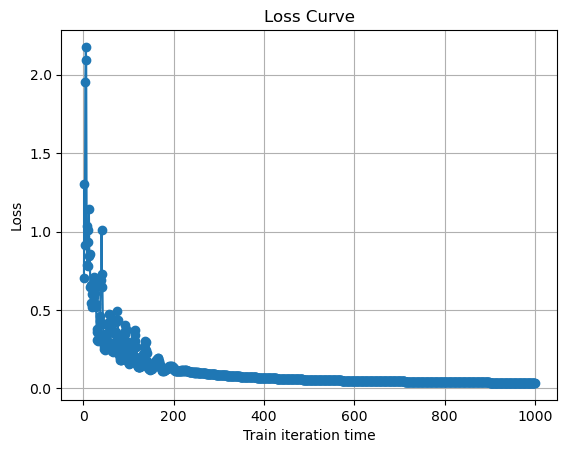

In [68]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

loss_values = logistic_regression.cost_

epochs = list(range(1, len(loss_values) + 1))

plt.plot(epochs, loss_values, marker='o')
plt.xlabel('Train iteration time')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.show()


### - Confusion matrix

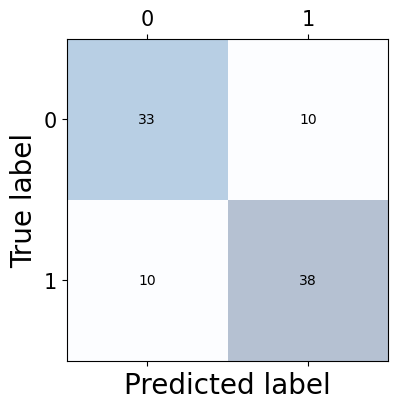

In [69]:
from sklearn.metrics import confusion_matrix
import os 

y_pred = logistic_regression.predict(X_test_std)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
if not os.path.exists('./output'):
    os.makedirs('./output')
plt.savefig('./output/fig-logistic-regression-confusion-2.png', dpi=300)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

### - F1 score

In [70]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true=y_test, y_pred=y_pred, pos_label=0)

print(f1)

0.7674418604651162
